In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np

### Plotting imports ###
import seaborn as sns
from seaborn_patch import SeabornFig2Grid as sfg
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
#mpl.rcParams['savefig.dpi'] = 300
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_context("notebook")
sns.set_theme(style="ticks", palette="muted")
#sns.set_theme(style="ticks", palette="muted", \
#              rc={'savefig.dpi': 300, 'figure.dpi': 600, 'figure.figsize': (3, 2)})
%matplotlib inline

In [2]:
# Read the grid optimization results:
align_df = pd.read_csv('align-opti_res.csv')
mask = ~align_df['unique_anno'].isna()
align_df['unique_anno_str'] = [v if pd.isna(v) else str(v) for v in align_df['unique_anno'].values]
align_df['unique_anno_float'] = align_df['unique_anno'] * 1.0
align_df.head(3)

,sample_name_unique,Mapping_percent,percent_single_annotation,percent_multiple_codons,unique_anno,frac_max_score,min_mut_freq,iteration,unique_anno_str,unique_anno_float
0,0m_1,99.318006,69.906075,10.152966,NaN,NaN,NaN,NaN,NaN,NaN
1,8m_1,98.875183,69.616756,12.981849,NaN,NaN,NaN,NaN,NaN,NaN
2,32m_1,99.365132,70.108498,10.173923,NaN,NaN,NaN,NaN,NaN,NaN


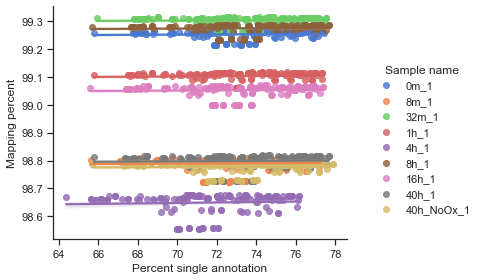

In [3]:
# Is there a trade-off between mapping success
# and annotation uniqueness?
# Looks like the answer is no:
g1 = sns.lmplot(data=align_df[mask], y='Mapping_percent', x='percent_single_annotation', \
                hue='sample_name_unique', aspect=1.3, height=4)
g1.ax.set_xlabel('Percent single annotation')
g1.ax.set_ylabel('Mapping percent')
g1.legend.set_title('Sample name')
g1.savefig('plots/map_trade-off_anno.pdf', bbox_inches='tight')
g1.savefig('plots/map_trade-off_anno.png', bbox_inches='tight', dpi=300)

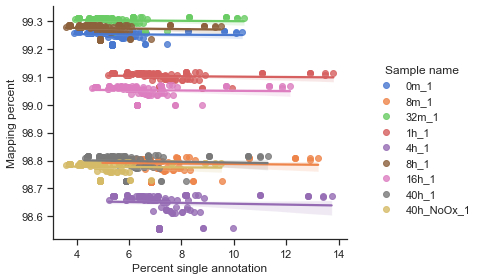

In [4]:
# Is there a trade-off between mapping success
# and percent multiple codon annotation?
# Looks like the answer is no:
g1 = sns.lmplot(data=align_df[mask], y='Mapping_percent', x='percent_multiple_codons', \
                hue='sample_name_unique', aspect=1.3, height=4)
g1.ax.set_xlabel('Percent single annotation')
g1.ax.set_ylabel('Mapping percent')
g1.legend.set_title('Sample name')
g1.savefig('plots/map_trade-off_codon.pdf', bbox_inches='tight')
g1.savefig('plots/map_trade-off_codon.png', bbox_inches='tight', dpi=300)

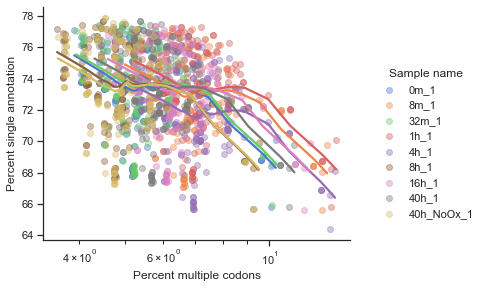

In [5]:
# Is there a correlation between annotation uniqueness
# and percent multiple codons:
g1 = sns.lmplot(data=align_df[mask], y='percent_single_annotation', x='percent_multiple_codons', \
                hue='sample_name_unique', aspect=1.3, height=4, lowess=True, scatter_kws={'alpha':0.4})
g1.ax.set(xscale="log")
g1.ax.set_ylabel('Percent single annotation')
g1.ax.set_xlabel('Percent multiple codons')
g1.legend.set_title('Sample name')
g1.savefig('plots/correlation_anno-codon.pdf', bbox_inches='tight')
g1.savefig('plots/correlation_anno-codon.png', bbox_inches='tight', dpi=300)

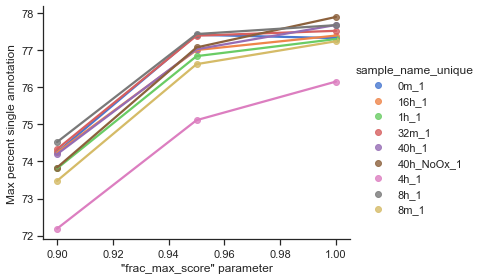

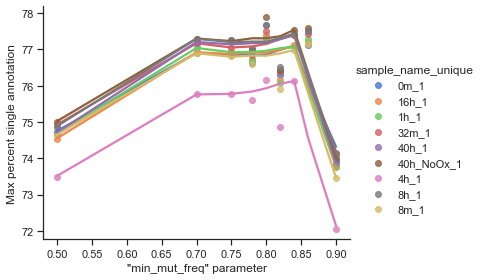

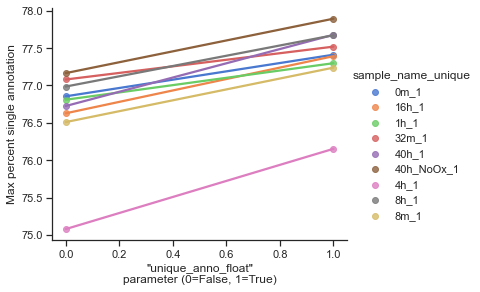

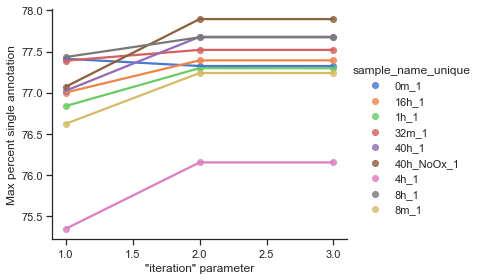

In [6]:
# Use data aggregation to find the max percentage
# of single annotations accross all optimized parameters
# but with the same "frac_max_score" paramter:
fmc_max_agg = align_df[mask].groupby(['sample_name_unique', 'frac_max_score']).agg({'percent_single_annotation': 'max'}).reset_index()

# Plot the aggregation results:
fmc_fig = sns.lmplot(data=fmc_max_agg, x='frac_max_score', y='percent_single_annotation', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
fmc_fig.ax.set_xlabel('"frac_max_score" parameter')
fmc_fig.ax.set_ylabel('Max percent single annotation');

# Now aggregate on the "min_mut_freq" parameter:
mm_max_agg = align_df[mask].groupby(['sample_name_unique', 'min_mut_freq']).agg({'percent_single_annotation': 'max'}).reset_index()
mm_fig = sns.lmplot(data=mm_max_agg, x='min_mut_freq', y='percent_single_annotation', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
mm_fig.ax.set_xlabel('"min_mut_freq" parameter')
mm_fig.ax.set_ylabel('Max percent single annotation');

# Now aggregate on the "unique_anno" parameter:
ua_max_agg = align_df[mask].groupby(['sample_name_unique', 'unique_anno_float']).agg({'percent_single_annotation': 'max'}).reset_index()
ua_fig = sns.lmplot(data=ua_max_agg, x='unique_anno_float', y='percent_single_annotation', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
ua_fig.ax.set_xlabel('"unique_anno_float"\nparameter (0=False, 1=True)')
ua_fig.ax.set_ylabel('Max percent single annotation');

# Now aggregate on the "iteration" parameter:
it_max_agg = align_df[mask].groupby(['sample_name_unique', 'iteration']).agg({'percent_single_annotation': 'max'}).reset_index()
it_fig = sns.lmplot(data=it_max_agg, x='iteration', y='percent_single_annotation', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
it_fig.ax.set_xlabel('"iteration" parameter')
it_fig.ax.set_ylabel('Max percent single annotation');

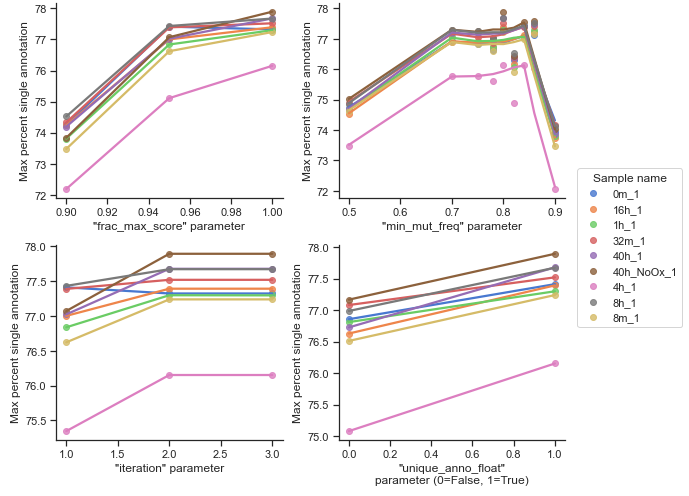

In [7]:
# Collect the above into one plot:
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(2, 2)

# Using the Seaborn patch to combine plots:
mg0 = sfg(fmc_fig, fig, gs[0])
mg1 = sfg(mm_fig, fig, gs[1])
mg2 = sfg(ua_fig, fig, gs[3])
mg3 = sfg(it_fig, fig, gs[2])

# Make legend:
handles = it_fig._legend_data.values()
labels = it_fig._legend_data.keys()
fig.legend(title='Sample name', handles=handles, labels=labels, loc='center right', \
           ncol=1, bbox_to_anchor = (1.2, 0.5))

gs.tight_layout(fig)
fig.savefig('plots/align-opti_params_anno.pdf', bbox_inches='tight')

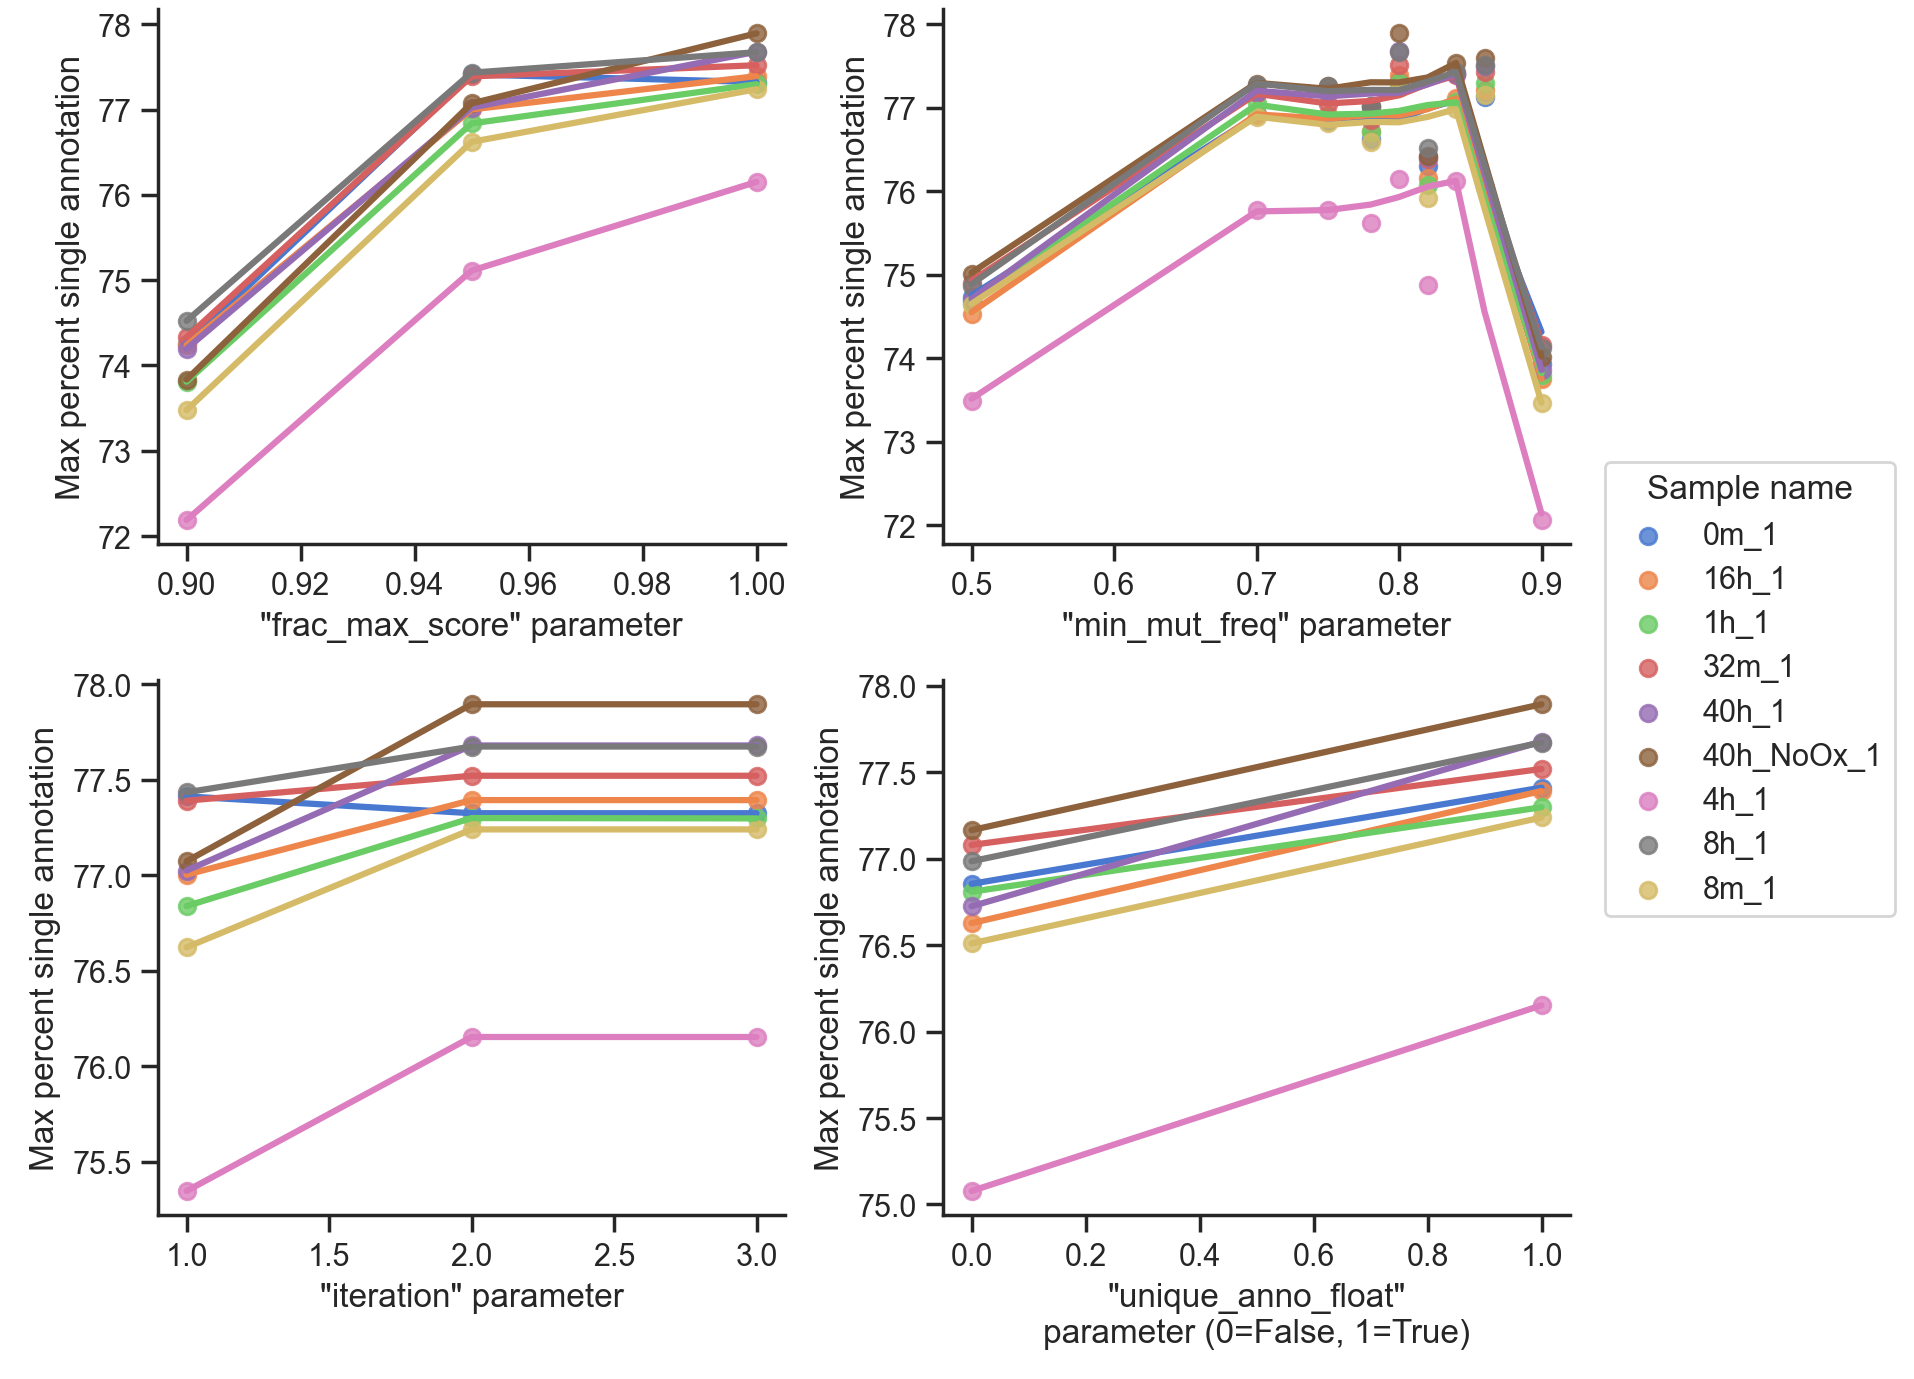

In [8]:
# dpi paramter does not work b/c the Seaborn patch
# does not change dpi settings on the copied axes:

# Below fixes that by changing the dpi settings
# for all figures:

fig = plt.figure(figsize=(8, 7))
fig.set_dpi(200)
gs = gridspec.GridSpec(2, 2)

fmc_fig.fig.set_dpi(200)
mm_fig.fig.set_dpi(200)
ua_fig.fig.set_dpi(200)
it_fig.fig.set_dpi(200)

# Using the Seaborn patch to combine plots:
mg0 = sfg(fmc_fig, fig, gs[0])
mg1 = sfg(mm_fig, fig, gs[1])
mg2 = sfg(ua_fig, fig, gs[3])
mg3 = sfg(it_fig, fig, gs[2])

# Make legend:
handles = it_fig._legend_data.values()
labels = it_fig._legend_data.keys()
fig.legend(title='Sample name', handles=handles, labels=labels, loc='center right', \
           ncol=1, bbox_to_anchor = (1.2, 0.5))

gs.tight_layout(fig)

fig.savefig('plots/align-opti_params_anno.png', bbox_inches='tight', dpi=200)

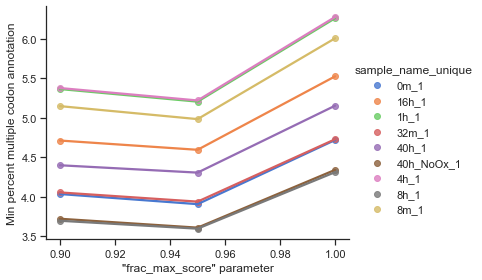

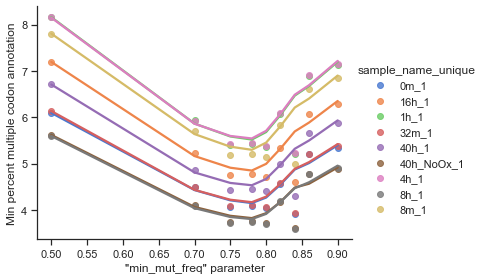

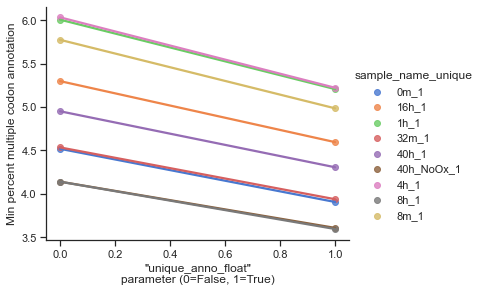

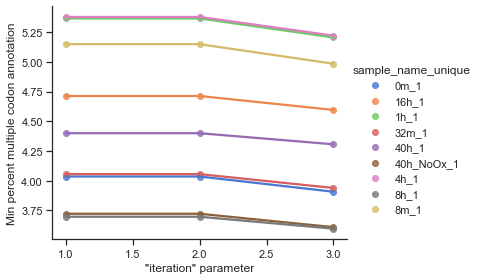

In [9]:
# Use data aggregation to find the min percentage
# of multiple codon annotation accross all optimized parameters
# but with the same "frac_max_score" paramter:
fmc_min_agg = align_df[mask].groupby(['sample_name_unique', 'frac_max_score']).agg({'percent_multiple_codons': 'min'}).reset_index()

# Plot the aggregation results:
fmc_fig = sns.lmplot(data=fmc_min_agg, x='frac_max_score', y='percent_multiple_codons', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
fmc_fig.ax.set_xlabel('"frac_max_score" parameter')
fmc_fig.ax.set_ylabel('Min percent multiple codon annotation');

# Now aggregate on the "min_mut_freq" parameter:
mm_min_agg = align_df[mask].groupby(['sample_name_unique', 'min_mut_freq']).agg({'percent_multiple_codons': 'min'}).reset_index()
mm_fig = sns.lmplot(data=mm_min_agg, x='min_mut_freq', y='percent_multiple_codons', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
mm_fig.ax.set_xlabel('"min_mut_freq" parameter')
mm_fig.ax.set_ylabel('Min percent multiple codon annotation');

# Now aggregate on the "unique_anno" parameter:
ua_min_agg = align_df[mask].groupby(['sample_name_unique', 'unique_anno_float']).agg({'percent_multiple_codons': 'min'}).reset_index()
ua_fig = sns.lmplot(data=ua_min_agg, x='unique_anno_float', y='percent_multiple_codons', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
ua_fig.ax.set_xlabel('"unique_anno_float"\nparameter (0=False, 1=True)')
ua_fig.ax.set_ylabel('Min percent multiple codon annotation');

# Now aggregate on the "iteration" parameter:
it_min_agg = align_df[mask].groupby(['sample_name_unique', 'iteration']).agg({'percent_multiple_codons': 'min'}).reset_index()
it_fig = sns.lmplot(data=it_min_agg, x='iteration', y='percent_multiple_codons', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
it_fig.ax.set_xlabel('"iteration" parameter')
it_fig.ax.set_ylabel('Min percent multiple codon annotation');

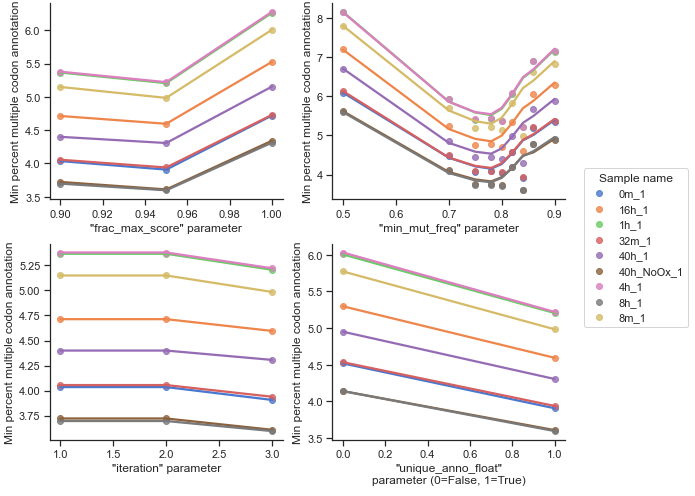

In [10]:
# Collect the above into one plot:
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(2, 2)

# Using the Seaborn patch to combine plots:
mg0 = sfg(fmc_fig, fig, gs[0])
mg1 = sfg(mm_fig, fig, gs[1])
mg2 = sfg(ua_fig, fig, gs[3])
mg3 = sfg(it_fig, fig, gs[2])

# Make legend:
handles = it_fig._legend_data.values()
labels = it_fig._legend_data.keys()
fig.legend(title='Sample name', handles=handles, labels=labels, loc='center right', \
           ncol=1, bbox_to_anchor = (1.2, 0.5))

gs.tight_layout(fig)
fig.savefig('plots/align-opti_params_codon.pdf', bbox_inches='tight')

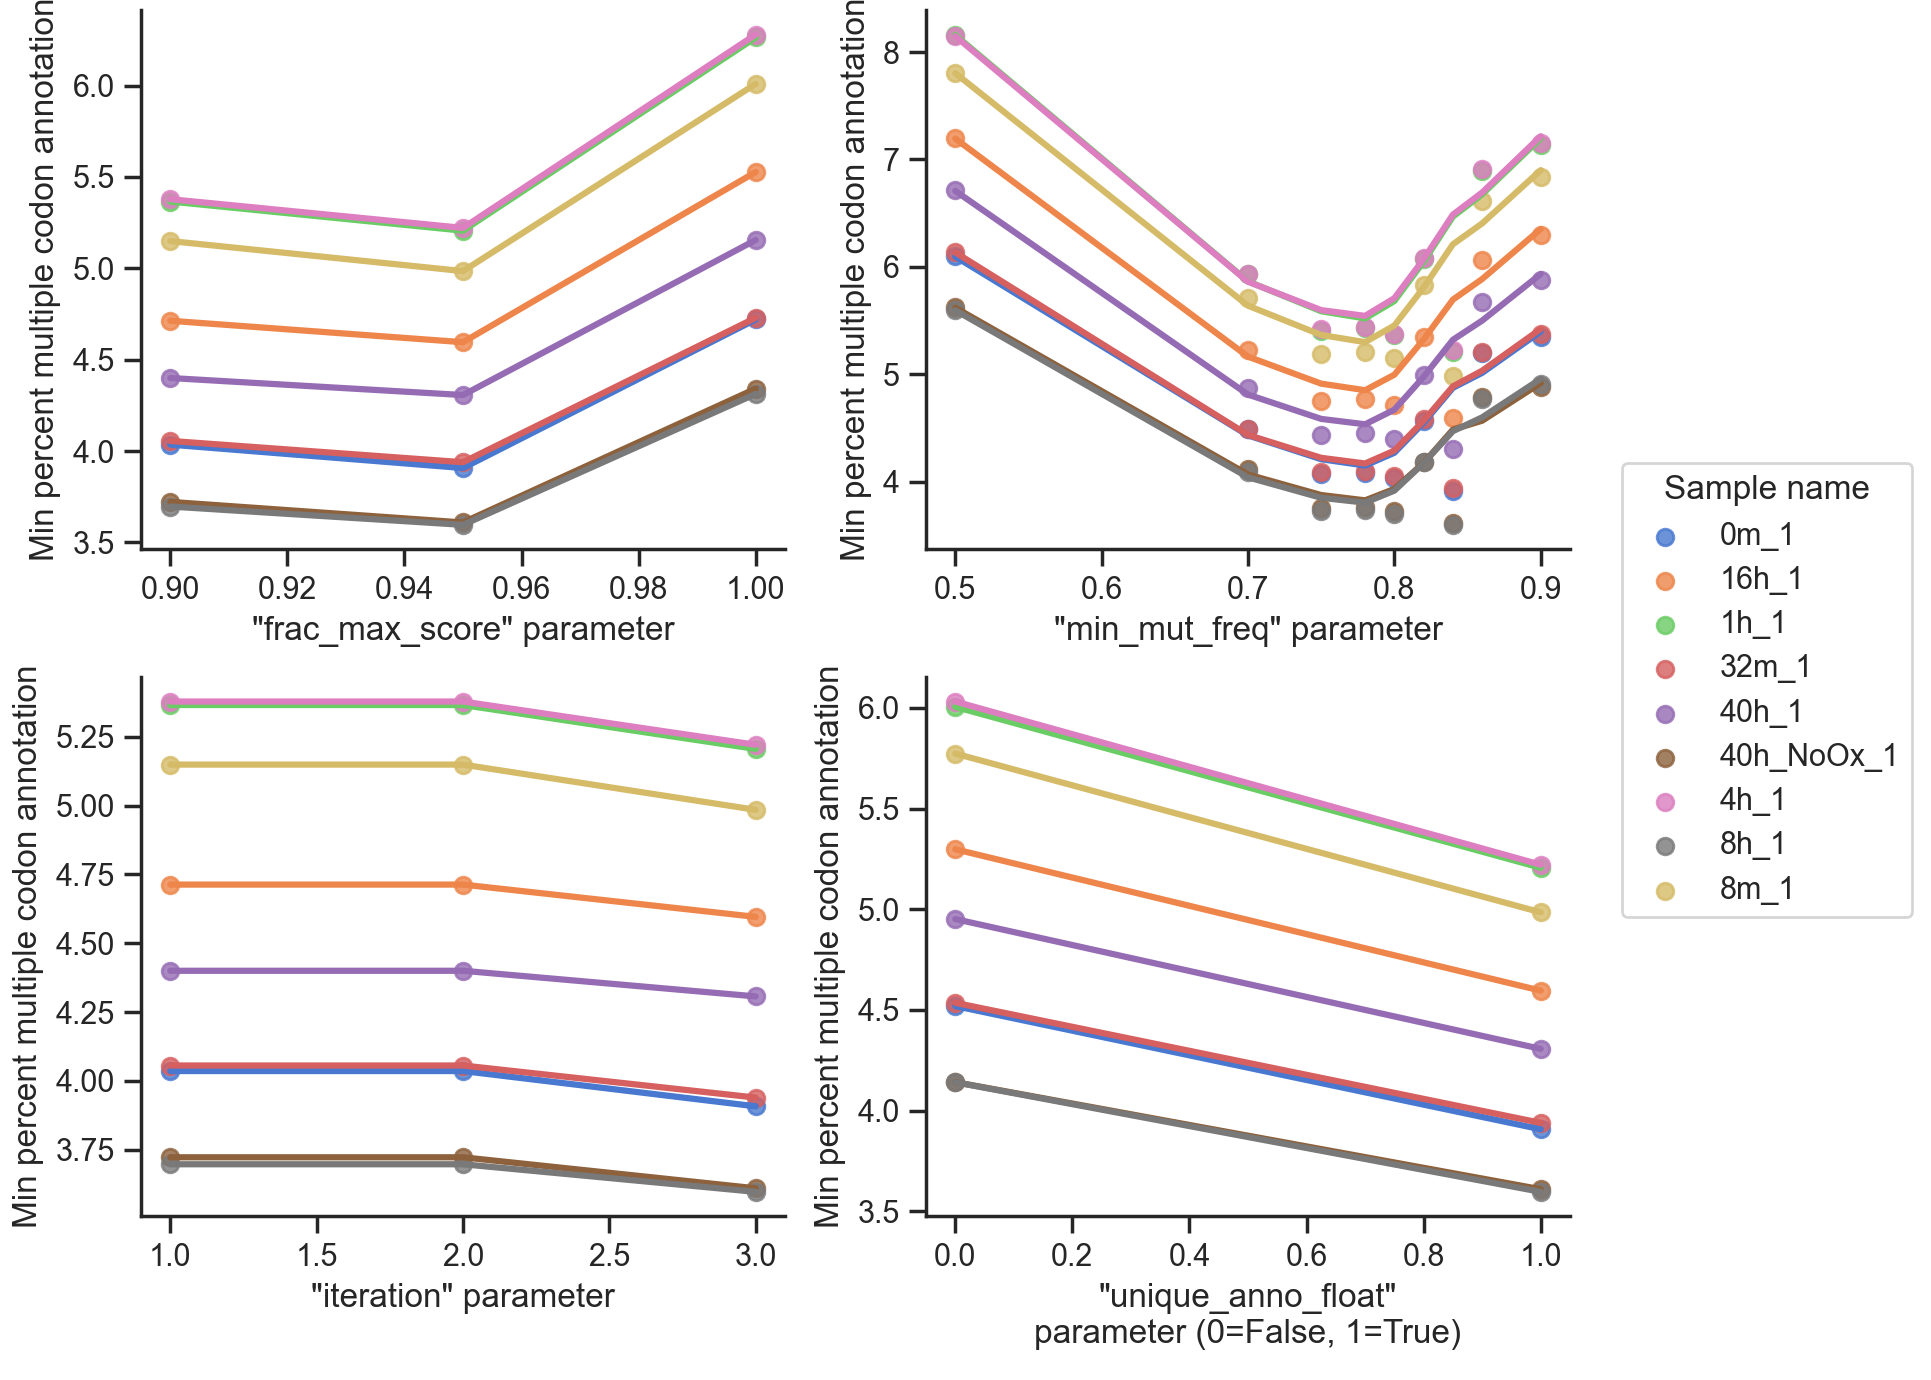

In [11]:
# dpi paramter does not work b/c the Seaborn patch
# does not change dpi settings on the copied axes:

# Below fixes that by changing the dpi settings
# for all figures:

fig = plt.figure(figsize=(8, 7))
fig.set_dpi(200)
gs = gridspec.GridSpec(2, 2)

fmc_fig.fig.set_dpi(200)
mm_fig.fig.set_dpi(200)
ua_fig.fig.set_dpi(200)
it_fig.fig.set_dpi(200)

# Using the Seaborn patch to combine plots:
mg0 = sfg(fmc_fig, fig, gs[0])
mg1 = sfg(mm_fig, fig, gs[1])
mg2 = sfg(ua_fig, fig, gs[3])
mg3 = sfg(it_fig, fig, gs[2])

# Make legend:
handles = it_fig._legend_data.values()
labels = it_fig._legend_data.keys()
fig.legend(title='Sample name', handles=handles, labels=labels, loc='center right', \
           ncol=1, bbox_to_anchor = (1.2, 0.5))

gs.tight_layout(fig)

fig.savefig('plots/align-opti_params_codon.png', bbox_inches='tight', dpi=200)

In [12]:
# Find the best alignment parameter combination
# for each sample for increasing mapping uniqueness:
best_res = align_df[mask].groupby(['sample_name_unique']).agg({'percent_single_annotation': 'max'}).reset_index()

max_row_list = list()
for _, row in best_res.iterrows():
    snu_mask = align_df['sample_name_unique'] == row['sample_name_unique']
    sam_ser = align_df.loc[snu_mask, 'percent_single_annotation']
    max_idx = sam_ser[sam_ser == row['percent_single_annotation']].index.values
    
    for mid in max_idx:
        max_row_list.append(align_df.loc[mid, :])

# Make rows into dataframe and extract max iteration
# if two iterations have the same "percent_single_annotation":
best_df = pd.DataFrame(max_row_list)
best_df_grp = best_df.groupby(['sample_name_unique', 'Mapping_percent', \
                               'percent_single_annotation', 'unique_anno', \
                               'frac_max_score', 'min_mut_freq']).agg({'iteration': 'max'}).reset_index()
# Find and count all the parameter combinations:
pivot_cols = ['unique_anno', 'iteration', 'frac_max_score', 'min_mut_freq']
param_combi = pd.pivot_table(best_df_grp.loc[:, pivot_cols], \
                             index=pivot_cols, aggfunc='size')
param_combi = param_combi.to_frame().reset_index().rename(columns={0: 'Count'})

In [13]:
best_df_grp

,sample_name_unique,Mapping_percent,percent_single_annotation,unique_anno,frac_max_score,min_mut_freq,iteration
0,0m_1,99.255876,77.411776,True,0.95,0.84,1.0
1,16h_1,99.064603,77.392267,True,1.00,0.80,3.0
2,1h_1,99.094041,77.298269,True,1.00,0.86,2.0
3,32m_1,99.312271,77.519823,True,1.00,0.80,3.0
4,40h_1,98.814983,77.678264,True,1.00,0.80,3.0
5,40h_NoOx_1,98.789261,77.893949,True,1.00,0.80,3.0
6,4h_1,98.673111,76.152199,True,1.00,0.80,3.0
7,8h_1,99.284848,77.672722,True,1.00,0.80,3.0
8,8m_1,98.805611,77.238855,True,1.00,0.80,3.0


In [14]:
param_combi

,unique_anno,iteration,frac_max_score,min_mut_freq,Count
0,True,1.0,0.95,0.84,1
1,True,2.0,1.00,0.86,1
2,True,3.0,1.00,0.80,7


In [15]:
# Find the best alignment parameter combination
# for each sample for decreasing multiple codon alignment:
best_res = align_df[mask].groupby(['sample_name_unique']).agg({'percent_multiple_codons': 'min'}).reset_index()

max_row_list = list()
for _, row in best_res.iterrows():
    snu_mask = align_df['sample_name_unique'] == row['sample_name_unique']
    sam_ser = align_df.loc[snu_mask, 'percent_multiple_codons']
    max_idx = sam_ser[sam_ser == row['percent_multiple_codons']].index.values
    
    for mid in max_idx:
        max_row_list.append(align_df.loc[mid, :])

# Make rows into dataframe and extract max iteration
# if two iterations have the same "percent_multiple_codons":
best_df = pd.DataFrame(max_row_list)
best_df_grp = best_df.groupby(['sample_name_unique', 'Mapping_percent', \
                               'percent_multiple_codons', 'unique_anno', \
                               'frac_max_score', 'min_mut_freq']).agg({'iteration': 'max'}).reset_index()
# Find and count all the parameter combinations:
pivot_cols = ['unique_anno', 'iteration', 'frac_max_score', 'min_mut_freq']
param_combi = pd.pivot_table(best_df_grp.loc[:, pivot_cols], \
                             index=pivot_cols, aggfunc='size')
param_combi = param_combi.to_frame().reset_index().rename(columns={0: 'Count'})

In [16]:
best_df_grp

,sample_name_unique,Mapping_percent,percent_multiple_codons,unique_anno,frac_max_score,min_mut_freq,iteration
0,0m_1,99.256592,3.907229,True,0.95,0.84,3.0
1,16h_1,99.059007,4.595719,True,0.95,0.84,3.0
2,1h_1,99.107006,5.205927,True,0.95,0.84,3.0
3,32m_1,99.307074,3.939001,True,0.95,0.84,3.0
4,40h_1,98.808202,4.306654,True,0.95,0.84,3.0
5,40h_NoOx_1,98.783258,3.609341,True,0.95,0.84,3.0
6,4h_1,98.659888,5.220980,True,0.95,0.84,3.0
7,8h_1,99.279672,3.596492,True,0.95,0.84,3.0
8,8m_1,98.797719,4.984644,True,0.95,0.84,3.0


In [17]:
param_combi

,unique_anno,iteration,frac_max_score,min_mut_freq,Count
0,True,3.0,0.95,0.84,9


In [18]:
# Printing the alignment stats
# using the unmasked tRNA database:
align_df[~mask]

,sample_name_unique,Mapping_percent,percent_single_annotation,percent_multiple_codons,unique_anno,frac_max_score,min_mut_freq,iteration,unique_anno_str,unique_anno_float
0,0m_1,99.318006,69.906075,10.152966,NaN,NaN,NaN,NaN,NaN,NaN
1,8m_1,98.875183,69.616756,12.981849,NaN,NaN,NaN,NaN,NaN,NaN
2,32m_1,99.365132,70.108498,10.173923,NaN,NaN,NaN,NaN,NaN,NaN
3,1h_1,99.168903,69.844230,13.541266,NaN,NaN,NaN,NaN,NaN,NaN
4,4h_1,98.734443,68.311800,13.509756,NaN,NaN,NaN,NaN,NaN,NaN
5,8h_1,99.312610,70.055625,9.301235,NaN,NaN,NaN,NaN,NaN,NaN
6,16h_1,99.091830,69.858448,11.939178,NaN,NaN,NaN,NaN,NaN,NaN
7,40h_1,98.825155,69.898782,11.106689,NaN,NaN,NaN,NaN,NaN,NaN
8,40h_NoOx_1,98.845296,69.873547,9.344536,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
align_df.loc[~mask, ['Mapping_percent', 'percent_single_annotation', 'percent_multiple_codons']].mean()

Mapping_percent              99.059617
percent_single_annotation    69.719307
percent_multiple_codons      11.339044
dtype: float64

In [20]:
# And then printing these stats for the
# best parameters for minimizing the mapping
# to multiple codons:
param_choice = (align_df['unique_anno']) & (align_df['iteration'] == 3) & (align_df['frac_max_score'] == 0.95) & (align_df['min_mut_freq'] == 0.84)
align_df[param_choice]

,sample_name_unique,Mapping_percent,percent_single_annotation,percent_multiple_codons,unique_anno,frac_max_score,min_mut_freq,iteration,unique_anno_str,unique_anno_float
432,0m_1,99.256592,77.097701,3.907229,True,0.95,0.84,3.0,True,1.0
433,8m_1,98.797719,76.312494,4.984644,True,0.95,0.84,3.0,True,1.0
434,32m_1,99.307074,77.059698,3.939001,True,0.95,0.84,3.0,True,1.0
435,1h_1,99.107006,76.560246,5.205927,True,0.95,0.84,3.0,True,1.0
436,4h_1,98.659888,74.785709,5.220980,True,0.95,0.84,3.0,True,1.0
437,8h_1,99.279672,77.159365,3.596492,True,0.95,0.84,3.0,True,1.0
438,16h_1,99.059007,76.805756,4.595719,True,0.95,0.84,3.0,True,1.0
439,40h_1,98.808202,76.733206,4.306654,True,0.95,0.84,3.0,True,1.0
440,40h_NoOx_1,98.783258,76.646695,3.609341,True,0.95,0.84,3.0,True,1.0


In [21]:
align_df.loc[param_choice, ['Mapping_percent', 'percent_single_annotation', 'percent_multiple_codons']].mean()

Mapping_percent              99.006491
percent_single_annotation    76.573430
percent_multiple_codons       4.373999
dtype: float64

In [22]:
# In conclusion:
# These parameters generated a masked tRNA database
# resulting in alignment statistics with a negligible 
# decrease in mapping percentage but a large
# improvement of alignment quality i.e. more unique
# mapping and much less mapping to multiple codons.